**I. Objective and Data**

We will use the OpenMIC-2018 dataset (https://zenodo.org/records/1432913). It contains 10-second audio recordings of different musical instruments. It also contains the processed dataset which encodes the original data as 128-dimensional vectors through the VGGish embedding (a neural network model). We will use this processed dataset to perform clustering of the different instruments, and see whether the addition of principal component analysis could improve the base model.

In [1]:
from pandas import read_csv, DataFrame, merge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import skew
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

We will strict our attention to those audio samples that have been agreed as a single instrument by the human verifiers. We extract this data below. The VGGish embedding of an audio sample divide the sample into 10 time frames, each of which has a 128-dimensional data. First, let us get the full data.

In [2]:
def get_data(reprocess):
    #if reprocess = True, build the dataframe from the source csv files, save this dataframe
    #if reproces = False, build the dataframe from the saved dataframe
    
    if reprocess:
        path = "openmic-2018"
        file = "openmic-2018-aggregated-labels.csv"
        df_labels = read_csv(os.path.join(path,file))
        df_labels = df_labels.rename(columns={"sample_key":"clip_id"})
    
        #audio clips with single instrument
        df_unique = (df_labels.groupby('clip_id').filter(lambda g: g["instrument"].nunique() == 1)).reset_index(drop=True)
        df_unique = df_unique[["clip_id","instrument"]]
    
        vggish_folder_path = os.path.join(path,"vggish")
        rows = []
        for clip_id in df_unique['clip_id']:
            folder = clip_id[:3]
            subfolder = os.path.join(vggish_folder_path,folder)
            file = clip_id + ".json"
            file_path = os.path.join(subfolder,file)
            
            with open(file_path,'r') as f:
                data = json.load(f)
                
            frames = data['features']  # shape: (n_frames, 128)
            row_data = [clip_id]
            for frame in frames:
                row_data += frame
            
            rows.append(row_data)
    
        columns = ['clip_id']
        for j in range(len(frames)):      
            columns += [f'vggish_{i}_f{j}' for i in range(128)]
        df_data = DataFrame(rows, columns=columns)
        df = merge(df_data, df_unique, on='clip_id', how='inner')
        df.to_csv("data_single_instrument_vggish_embedding.csv")   
    else:
        df = read_csv("data_single_instrument_vggish_embedding.csv")  
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        
    return df

In [3]:
df_full = get_data(False)
df_full.head()

,clip_id,vggish_0_f0,vggish_1_f0,vggish_2_f0,vggish_3_f0,vggish_4_f0,vggish_5_f0,vggish_6_f0,vggish_7_f0,vggish_8_f0,...,vggish_119_f9,vggish_120_f9,vggish_121_f9,vggish_122_f9,vggish_123_f9,vggish_124_f9,vggish_125_f9,vggish_126_f9,vggish_127_f9,instrument
0,000139_119040,190,44,215,107,201,68,75,69,102,...,86,255,255,235,95,255,0,105,255,accordion
1,000145_172800,182,26,194,95,195,125,122,94,98,...,95,255,43,123,42,158,0,0,255,accordion
2,000154_288000,175,9,151,95,166,35,117,134,132,...,117,68,89,12,168,114,0,22,255,mallet_percussion
3,000178_3840,171,34,165,96,228,44,121,99,126,...,216,53,131,183,69,178,208,0,255,voice
4,000189_207360,181,17,170,113,191,88,110,134,83,...,99,177,136,204,46,255,0,66,255,guitar


Let us first apply KMeans to this raw data to classify the instruments. We will use the adjusted_rand_score (ARS) as to measure the accuracy of the predicted clusters with respect to the actual clusters. We will vary the number of time frames we use in the data, from only consider the 1st time frame (128 features), up to considering all the 10 time frames (10 x 128 features). We do this since we can presume that certain portion of the 10-second audio sample contains necessary distinguishing features of the instrument. 

In [4]:
for f in range(10):
    feature_labels = df_full.columns[1:(1+(f+1)*128)]

    X = df_full[feature_labels]
    k= len(df_full['instrument'].unique())
    kmeans = KMeans(n_clusters=k, random_state=123)
    clusters = kmeans.fit_predict(X)
    score = adjusted_rand_score(df_full['instrument'], clusters)
    print(f"Max frame: {f+1}", f"ARS: {score:.3f}")

Max frame: 1 ARS: 0.078
Max frame: 2 ARS: 0.124
Max frame: 3 ARS: 0.140
Max frame: 4 ARS: 0.149
Max frame: 5 ARS: 0.173
Max frame: 6 ARS: 0.160
Max frame: 7 ARS: 0.163
Max frame: 8 ARS: 0.180
Max frame: 9 ARS: 0.220
Max frame: 10 ARS: 0.180


Interestingly, we see that ARS increases as more frames are used, and that using up to the 9th frame leads to high ARS. (Note: we checked with different random_state value and found either 8th to 9th frame lead to high ARS.) We will focus on KMeans, although I tried using other algorithms (DBSCAN, MeanShift, etc.) but it was difficult to tune them to work (not treat points as noise). GaussianMixture works but it has the same score as KMeans, specially in its default setting.

In [6]:
f10_features = [f"vggish_{i}_f9" for i in range(128)]
df = df_full.drop(f10_features,axis=1)
df.head()

,clip_id,vggish_0_f0,vggish_1_f0,vggish_2_f0,vggish_3_f0,vggish_4_f0,vggish_5_f0,vggish_6_f0,vggish_7_f0,vggish_8_f0,...,vggish_119_f8,vggish_120_f8,vggish_121_f8,vggish_122_f8,vggish_123_f8,vggish_124_f8,vggish_125_f8,vggish_126_f8,vggish_127_f8,instrument
0,000139_119040,190,44,215,107,201,68,75,69,102,...,38,255,163,90,154,255,49,58,255,accordion
1,000145_172800,182,26,194,95,195,125,122,94,98,...,253,116,0,91,0,254,65,0,255,accordion
2,000154_288000,175,9,151,95,166,35,117,134,132,...,103,35,0,17,20,255,103,126,255,mallet_percussion
3,000178_3840,171,34,165,96,228,44,121,99,126,...,203,0,34,130,37,163,255,14,255,voice
4,000189_207360,181,17,170,113,191,88,110,134,83,...,167,26,255,202,77,255,0,164,255,guitar


Let us look at how many observations are there per instrument.

In [8]:
counts = df['instrument'].value_counts()
counts

instrument
mallet_percussion    731
flute                669
piano                643
organ                623
saxophone            554
accordion            535
bass                 529
cymbals              512
cello                490
violin               487
voice                458
ukulele              404
synthesizer          378
banjo                378
guitar               356
drums                342
trombone             204
mandolin             172
clarinet             155
trumpet               68
Name: count, dtype: int64

If we look at the number of observations per instrument, some have many observations and some have less. This could affect the efficiency of KMeans. For example, those with fewer observations could be misclustered to a different instrument cluster. Instead, let us consider the case with few instruments only to classify. Let us take those that have the largest number of observations to represent their instrument category (Strings, woodwind, etc.). Hence, we take flute to represent woodwind instruments, piano to represented plucked string instruments, cello to represent bowed string instruments, and trombone to represent brass instruments.

In [7]:
chosen_instruments = ["flute","piano","cello","trombone"]
df_chosen = df[df['instrument'].isin(chosen_instruments)].reset_index()
feature_labels =  df_full.columns[1:(1+9*128)]

X = df_chosen[feature_labels]
k= len(df_chosen['instrument'].unique())
kmeans = KMeans(n_clusters=k, random_state=123)
clusters = kmeans.fit_predict(X)
score = adjusted_rand_score(df_chosen['instrument'], clusters)
print(f"ARS: {score:.3f}")

ARS: 0.439


This is a good starting point, ARS of 0.439, as more than 40% is properly clustered. Let us also look at a different case, that is, how well can we apply KMeans within a category of instruments.

In [8]:
instrument_mapping = {
    "accordion": "Keyboard",
    "mallet_percussion": "Percussion",
    "voice": "Vocal",
    "guitar": "String_plucked",
    "banjo": "String_plucked",
    "piano": "String_plucked",
    "organ": "Keyboard",
    "ukulele": "String_plucked",
    "trombone": "Brass",
    "bass": "String_plucked",
    "synthesizer": "Electronic",
    "cymbals": "Percussion",
    "drums": "Percussion",
    "mandolin": "String_plucked",
    "flute": "Woodwind",
    "violin": "String_bowed",
    "saxophone": "Woodwind",
    "cello": "String_bowed",
    "trumpet": "Brass",
    "clarinet": "Woodwind"
}
df["category"] = df["instrument"].map(instrument_mapping)
counts = df['category'].value_counts()
counts

category
String_plucked    2482
Percussion        1585
Woodwind          1378
Keyboard          1158
String_bowed       977
Vocal              458
Electronic         378
Brass              272
Name: count, dtype: int64

Let us consider the categories with many observations, i.e. plucked string, percussion, woodwind, keyboard, and bowed string.

In [9]:
categories = ["String_plucked","Percussion","Keyboard","String_bowed","Woodwind"]

for category in categories:
    df_cat = df[df["category"] == category]
    
    X = df_cat[feature_labels]
    k= len(df_cat['instrument'].unique())
    kmeans = KMeans(n_clusters=k, random_state=123)
    clusters = kmeans.fit_predict(X)
    score = adjusted_rand_score(df_cat['instrument'], clusters)
    print(category,":",k,":",f"ARS: {score:.3f}")

String_plucked : 6 : ARS: 0.376
Percussion : 3 : ARS: 0.329
Keyboard : 2 : ARS: 0.384
String_bowed : 2 : ARS: 0.706
Woodwind : 3 : ARS: 0.469


Within the categories, we can see that it does well in the category of bowed string instruments. We may attribute this to having only two instruments in this category, violin and cello, which have a small overlap in their tonal range. The poor peformance in the plucked string category can be attributed to having many instruments with good tonal range overlap with one another, e.g. piano has a range that overlaps with the other instruments. 

**II. KMeans with Scaled Data**

Let us see if scaling the data can improve these scores. We consider StandardScaler, MinMaxScaler, and RobustScaler

In [10]:
def get_score(df,label,X):
    k= len(df[label].unique())
    kmeans = KMeans(n_clusters=k, random_state=123)
    clusters = kmeans.fit_predict(X)
    score = adjusted_rand_score(df[label], clusters)
    return score  

def log_transform(df,features):
    skew_values = df[features].apply(lambda x: skew(x, nan_policy='omit'))
    skew_summary = DataFrame({
        'feature': df[features].columns,
        'skewness': skew_values
    }).sort_values(by='skewness', ascending=False)
    
    highly_skewed_features = skew_summary[skew_summary['skewness'] > 1].index.tolist()
    df_transformed = df.copy()
    df_transformed[highly_skewed_features] = np.log1p(df_transformed[highly_skewed_features])
    return df_transformed

In [11]:
X = df_chosen[feature_labels]
X_ss = StandardScaler().fit_transform(X)
score = get_score(df_chosen,'instrument',X_ss)
print("StandardScaler",f"ARI: {score:.3f}")

X_mms = MinMaxScaler().fit_transform(X)
score = get_score(df_chosen,'instrument',X_mms)
print("MinMaxScaler",f"ARI: {score:.3f}")

X_rs = RobustScaler().fit_transform(X)
score = get_score(df_chosen,'instrument',X_rs)
print("RobustScaler",f"ARI: {score:.3f}")

StandardScaler ARI: 0.479
MinMaxScaler ARI: 0.529
RobustScaler ARI: 0.481


We see here that MinMaxScaler has the best improved score of 0.529 from 0.439. However, there may be highly skewed data in some of the features. Hence, let us consider these scaling techniques in combination with log transformation (having identified the features with highly skewed data).

In [12]:
df_transformed = log_transform(df_chosen,feature_labels)
X = df_transformed[feature_labels]

X_ss = StandardScaler().fit_transform(X)
score = get_score(df_chosen,'instrument',X_ss)
print("StandardScaler",f"ARI: {score:.3f}")

X_mms = MinMaxScaler().fit_transform(X)
score = get_score(df_chosen,'instrument',X_mms)
print("MinMaxScaler",f"ARI: {score:.3f}")

X_rs = RobustScaler().fit_transform(X)
score = get_score(df_chosen,'instrument',X_rs)
print("RobustScaler",f"ARI: {score:.3f}")

StandardScaler ARI: 0.570
MinMaxScaler ARI: 0.426
RobustScaler ARI: 0.491


We can see that our best option is the combination of StandardScaler and log transformation to bring the score from 0.439 to 0.570. Now, more than 50% is correctly clustered. Let us apply this in the case of clustering within known categories.

In [14]:
for category in categories:
    df_cat = df[df["category"] == category]
    df_transformed = log_transform(df_cat,feature_labels)
    
    X = df_transformed[feature_labels]
    X_ss = StandardScaler().fit_transform(X)
    score = get_score(df_transformed,'instrument',X_ss)
    print(category,":",k,":",f"ARS: {score:.3f}")

String_plucked : 3 : ARS: 0.211
Percussion : 3 : ARS: 0.345
Keyboard : 3 : ARS: 0.449
String_bowed : 3 : ARS: 0.675
Woodwind : 3 : ARS: 0.470


We have the scores change per category: plucked string 0.376 -> 0.211, percussion  0.329 -> 0.345, keyboard 0.384 -> 0.449, bowed string 0.706 -> 0.675, and woodwind 0.469 -> 0.470. Only with percussion, keyboard, and woodwind we see increased scores, albeit small (and not going over the 50% threshold we would have liked).

**III. KMeans with Scaled Data and PCA**

Let us now consider if using PCA can improve the scores. The dimension of the features now is 9x128 = 1152. Let us consider the range 10 to 350 for the PCA's n_component to test the PCA.

In [38]:
df_transformed = log_transform(df_chosen,feature_labels)
X = df_transformed[feature_labels]
X_ss = StandardScaler().fit_transform(X)

In [ ]:
scores = []
n_components = range(10,350)
for n in n_components:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_ss)
    score = get_score(df_chosen,'instrument',X_pca)
    scores.append(score)

The PCA with the best improved score within the considered range of n_component is with n_component = 82 with score 0.616


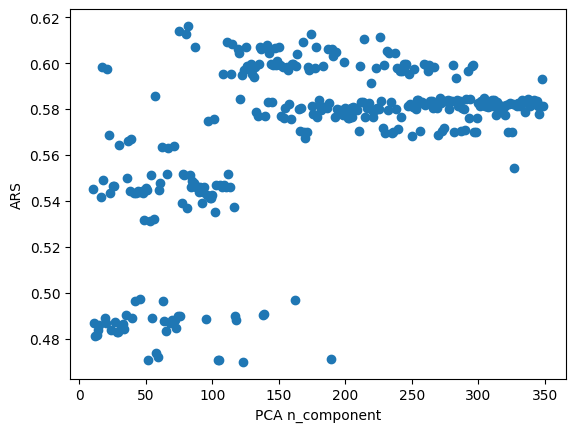

In [30]:
n_comp_max = list(n_components)[scores.index(np.max(scores))]
print("The PCA with the best improved score within the considered range of n_component is with n_component =",n_comp_max,"with score", np.round(np.max(scores),3))

plt.scatter(n_components,scores)
plt.xlabel("PCA n_component")
plt.ylabel("ARS")
plt.show()

In the considered range, we were able to improve the score from 0.570 to 0.616 using a PCA with 82 dimensions. Let us apply this setting to the clustering within known categories.

In [36]:
for category in categories:
    df_cat = df[df["category"] == category]
    df_transformed = log_transform(df_cat,feature_labels)
    
    X = df_transformed[feature_labels]
    X_ss = StandardScaler().fit_transform(X)
    X_pca = PCA(n_components = n_comp_max).fit_transform(X_ss)
    score = get_score(df_transformed,'instrument',X_pca)
    print(category,":",k,":",f"ARS: {score:.3f}")

String_plucked : 3 : ARS: 0.268
Percussion : 3 : ARS: 0.342
Keyboard : 3 : ARS: 0.449
String_bowed : 3 : ARS: 0.675
Woodwind : 3 : ARS: 0.472


We have the scores change per category (from the no-scaling Kmeans): plucked string 0.376 -> 0.268, percussion  0.329 -> 0.342, keyboard 0.384 -> 0.449, bowed string 0.706 -> 0.675, and woodwind 0.469 -> 0.472. There is not much a difference with the changes brought by the addition of the PCA with 82 components. 

Let us now see whether KernelPCA can lead to better results.

In [31]:
scores = []
n_components = range(10,350)
for n in n_components:
    pca = KernelPCA(n_components=n,kernel="poly",degree=2)
    X_pca = pca.fit_transform(X_ss)
    score = get_score(df_chosen,'instrument',X_pca)
    scores.append(score)

The KernelPCA with the best improved score within the considered range of n_component is with n_component = 164 with score 0.595


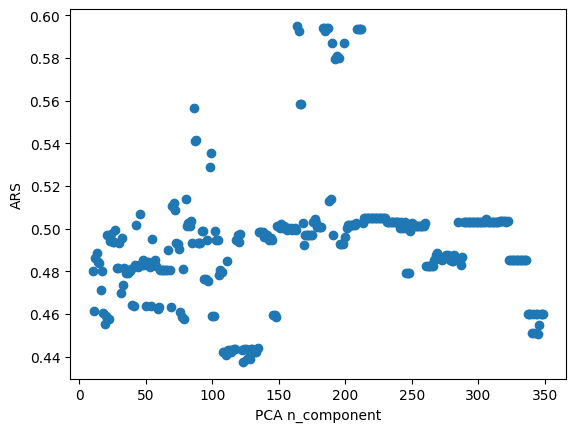

In [32]:
n_comp_max = list(n_components)[scores.index(np.max(scores))]
print("The KernelPCA with the best improved score within the considered range of n_component is with n_component =",n_comp_max,"with score", np.round(np.max(scores),3))

plt.scatter(n_components,scores)
plt.xlabel("KernelPCA n_component")
plt.ylabel("ARS")
plt.show()

In [33]:
scores = []
n_components = range(10,350)
for n in n_components:
    pca = KernelPCA(n_components=n,kernel="poly",degree=3)
    X_pca = pca.fit_transform(X_ss)
    score = get_score(df_chosen,'instrument',X_pca)
    scores.append(score)

The KernelPCA with the best improved score within the considered range of n_component is with n_component = 338 with score 0.551


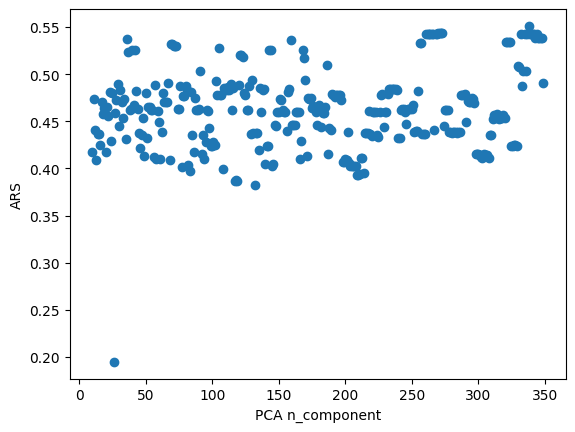

In [34]:
n_comp_max = list(n_components)[scores.index(np.max(scores))]
print("The KernelPCA with the best improved score within the considered range of n_component is with n_component =",n_comp_max,"with score", np.round(np.max(scores),3))

plt.scatter(n_components,scores)
plt.xlabel("KernelPCA n_component")
plt.ylabel("ARS")
plt.show()

In [41]:
scores = []
n_components = range(10,350)
for n in n_components:
    pca = KernelPCA(n_components=n,kernel="rbf")
    X_pca = pca.fit_transform(X_ss)
    score = get_score(df_chosen,'instrument',X_pca)
    scores.append(score)

The KernelPCA with the best improved score within the considered range of n_component is with n_component = 160 with score 0.593


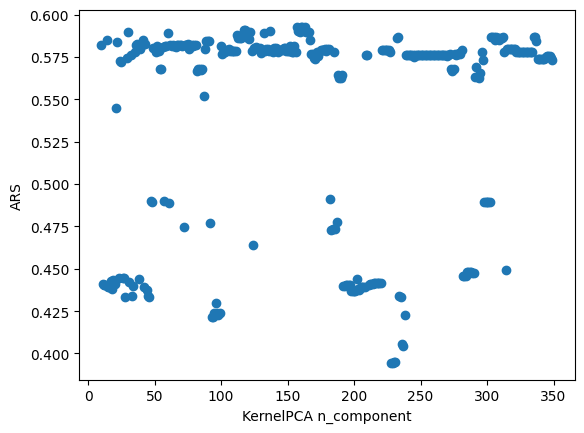

In [42]:
n_comp_max = list(n_components)[scores.index(np.max(scores))]
print("The KernelPCA with the best improved score within the considered range of n_component is with n_component =",n_comp_max,"with score", np.round(np.max(scores),3))

plt.scatter(n_components,scores)
plt.xlabel("KernelPCA n_component")
plt.ylabel("ARS")
plt.show()

We tried the KernelPCA with polynomial kernel with degree=2,3 and with rbf kernel. The best scores we obtained, within the considered range of n_components, are 0.595 (n = 164), 0.551 (n=338), and 0.593 (n=160), respectively. All of which are inferior to the results obtained from the PCA with 82 components, which essentially is a KernelPCA with a linear kernel. However, these scores are still far from the performance we would like for potential real-life use.  

**IV. Insights and Summary**

In this project, we applied clustering methods to the VGGish embeddings of the OpenMIC-2018 dataset to explore how well unsupervised learning can separate musical instruments. KMeans provided a reasonable baseline, with accuracy (ARS) improving as more time frames were included. Data scaling and log transformation yielded significant gains, with StandardScaler plus log transform raising ARS from 0.439 to 0.570. Incorporating PCA further improved performance, reaching 0.616 with 82 dimensions, while KernelPCA did not surpass this result.

These results suggest that preprocessing such as scaling, transformation, and dimensionality reduction, plays a critical role in improving clustering performance on high-dimensional audio embeddings. While scores improved moderately, clustering across instruments remains challenging due to, presumably, overlapping tonal ranges. Furthermore, some useful information may have been lost in the VGGish embedding process, restricting cluster separability. Future work could address this by working directly with the raw audio, for example through mel-spectrograms, MFCCs, or domain-adapted neural embeddings, which may preserve richer acoustic details and lead to more robust clustering outcomes.